In [98]:
from IPython.core.interactiveshell import InteractiveShell
from sklearn.tree import plot_tree

InteractiveShell.ast_node_interactivity = "all"

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


## Homework

> Note: sometimes your answer doesn't match one of
> the options exactly. That's fine.
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In [100]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')


In [101]:
data.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0


In [102]:
data.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [103]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['lead_score', 'number_of_courses_viewed', 'annual_income', 'interaction_count']

In [104]:
data.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [105]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna('NA')
    else:
        data[col] = data[col].fillna(0.0)
data.isnull().sum()


lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [106]:
df_full_train, df_full_test = train_test_split(data, test_size=0.2, random_state=1)
df_split_train, df_full_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train_y = df_split_train['converted'].values
df_train_x = df_split_train.drop('converted', axis=1).reset_index(drop=True)
df_test_y = df_full_test['converted'].values
df_test_x = df_full_test.drop('converted', axis=1).reset_index(drop=True)
df_val_y = df_full_val['converted'].values
df_val_x = df_full_val.drop('converted', axis=1).reset_index(drop=True)

In [107]:
print(f'df_train_x shape: {df_train_x.shape}, df_val_x shape: {df_val_x.shape}, df_test_x shape: {df_test_x.shape}')

df_train_x shape: (876, 8), df_val_x shape: (293, 8), df_test_x shape: (293, 8)




### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score` 0.6145
- `number_of_courses_viewed` 0.7636
- `interaction_count` 0.5520
- `annual_income` 0.7383

In [108]:
for v in numerical:
	print(f'score for {v}: {roc_auc_score(df_train_y, df_train_x[v])}')

score for lead_score: 0.6144993577250176
score for number_of_courses_viewed: 0.7635680590007088
score for annual_income: 0.5519578313253012
score for interaction_count: 0.738270176293409



### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [109]:
df_train_x.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
dtype: object

In [110]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train_x.to_dict('records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train_y)

val_dict = df_val_x.to_dict('records')
X_val = dv.transform(val_dict)

y_val_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(df_val_y, y_val_pred)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


0.8171316268814112

In [111]:
df_train_x.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score'],
      dtype='object')



### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

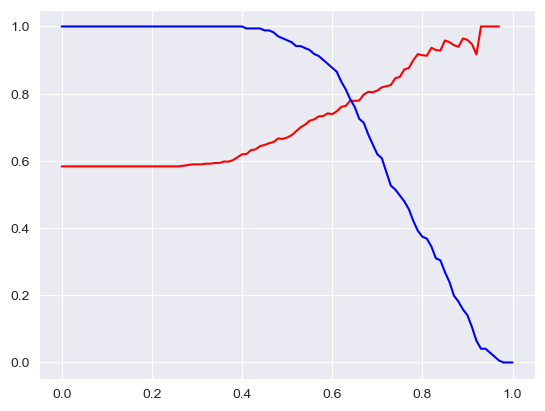

In [112]:
thresholds = np.linspace(0.0, 1.0, 101)
scores = []
# precision = how many positive predictions turned out to be correct
# fraction of positive predictions that are identified correctly TP / TP + FP

# get the number of positive predictions
for t in thresholds:
    actual_positive = (df_val_y == 1)
    actual_negative = (df_val_y == 0)

    predict_positive = (y_val_pred >= t)
    predict_negative = (y_val_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(thresholds, df_scores['precision'], label='precision', color='r')
plt.plot(thresholds, df_scores['recall'], label='recall', color='b')



In [124]:
diff = np.abs(df_scores['precision'] - df_scores['recall'])
diff.min()

0.0045559635522914865



### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


In [113]:
df_scores['F1'] = 2 * (df_scores.recall * df_scores.precision / (df_scores.recall + df_scores.precision))
df_scores[df_scores['F1'] == df_scores['F1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,F1
57,0.57,156,57,15,65,0.732394,0.912281,0.8125



### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [118]:
def train(training_df, y_training, C=1.0):
    dicts = training_df[categorical + numerical].to_dict('records')

    dvect = DictVectorizer(sparse=False)
    x_training = dvect.fit_transform(dicts)

    trained_model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    trained_model.fit(x_training, y_training)

    return dvect, trained_model

In [115]:
def predict(validate_df, dvect, trained_model):
	dicts = validate_df[categorical + numerical].to_dict('records')

	x = dvect.transform(dicts)
	y_pred = trained_model.predict_proba(x)[:,1]

	return y_pred


In [116]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_kfold_idx, val_kfold_idx in kfold.split(df_full_train):
    df_train_kfold = df_full_train.iloc[train_kfold_idx]
    df_val_kfold = df_full_train.iloc[val_kfold_idx]

    df_train_y_kfold = df_full_train.iloc[train_kfold_idx]['converted'].values
    df_val_y_kfold = df_full_train.iloc[val_kfold_idx]['converted'].values

    kfold_dv, kfold_model = train(df_train_kfold, df_train_y_kfold)
    kfold_y_pred = predict(df_val_kfold, kfold_dv, kfold_model)

    kfold_auc = roc_auc_score(df_val_y_kfold, kfold_y_pred)
    scores.append(kfold_auc)
    print(f'score: {kfold_auc}')

scores = np.array(scores)
print(scores)
scores.std()

score: 0.8060745924216483
score: 0.8713738368910783
score: 0.7754320118852139
score: 0.8018368617683685
score: 0.8558272713202291
[0.80607459 0.87137384 0.77543201 0.80183686 0.85582727]


np.float64(0.03580711942905165)



### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [121]:


for c in [0.000001, 0.001, 1]:
    scores = []

    for train_kfold_idx, val_kfold_idx in kfold.split(df_full_train):
        df_train_kfold = df_full_train.iloc[train_kfold_idx]
        df_val_kfold = df_full_train.iloc[val_kfold_idx]

        df_train_y_kfold = df_full_train.iloc[train_kfold_idx]['converted'].values
        df_val_y_kfold = df_full_train.iloc[val_kfold_idx]['converted'].values

        kfold_dv, kfold_model = train(df_train_kfold, df_train_y_kfold, C=c)
        kfold_y_pred = predict(df_val_kfold, kfold_dv, kfold_model)

        kfold_auc = roc_auc_score(df_val_y_kfold, kfold_y_pred)
        scores.append(kfold_auc)

    scores = np.array(scores)
    print(f'values for {c:.6f}: mean:{round(scores.mean(),3)} std:{round(scores.std(),3)}')

values for 0.000001: mean:0.56 std:0.024
values for 0.001000: mean:0.867 std:0.029
values for 1.000000: mean:0.822 std:0.036




## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one